# Exploratory Data Analysis - Chest X-ray Image Dataset

This notebook explores the Chest X-ray Image dataset, visualizes the images, and demonstrates the effects of our preprocessing and data augmentation techniques.

In [12]:
# Import required libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
import cv2
from torchvision import transforms
import random
from pathlib import Path

# Add parent directory to path to import custom modules
sys.path.append('..')
from utils.data_utils import (
    download_dataset, 
    load_img, 
    get_class_distribution,
    apply_clahe, 
    apply_adaptive_gamma, 
    apply_unsharp_masking, 
    apply_median_filter, 
    apply_random_grayscale
)

# Set matplotlib figure size
plt.rcParams['figure.figsize'] = (15, 10)

## 1. Load the Dataset

First, let's download and load the dataset if not already available. We'll also examine its structure.

In [13]:
# Download dataset if not already available
dataset_path = download_dataset("alsaniipe/chest-x-ray-image") + "/Data/"

# Display the dataset structure
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

# List classes in the dataset
classes = sorted(os.listdir(train_path))
print(f"Classes in the dataset: {classes}")

# Count number of images in each class
train_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in classes}
test_counts = {cls: len(os.listdir(os.path.join(test_path, cls))) for cls in classes}

print("\nNumber of training images per class:")
for cls, count in train_counts.items():
    print(f"  {cls}: {count}")

print("\nNumber of test images per class:")
for cls, count in test_counts.items():
    print(f"  {cls}: {count}")

total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
print(f"\nTotal training images: {total_train}")
print(f"Total test images: {total_test}")
print(f"Total images: {total_train + total_test}")

Baixando dataset...
Dataset baixado em: /home/luise/.cache/kagglehub/datasets/alsaniipe/chest-x-ray-image/versions/1
Classes in the dataset: ['COVID19', 'NORMAL', 'PNEUMONIA']

Number of training images per class:
  COVID19: 460
  NORMAL: 1266
  PNEUMONIA: 3418

Number of test images per class:
  COVID19: 116
  NORMAL: 317
  PNEUMONIA: 855

Total training images: 5144
Total test images: 1288
Total images: 6432


## 2. Visualize Original Images

Let's visualize a few original images from each class.

12


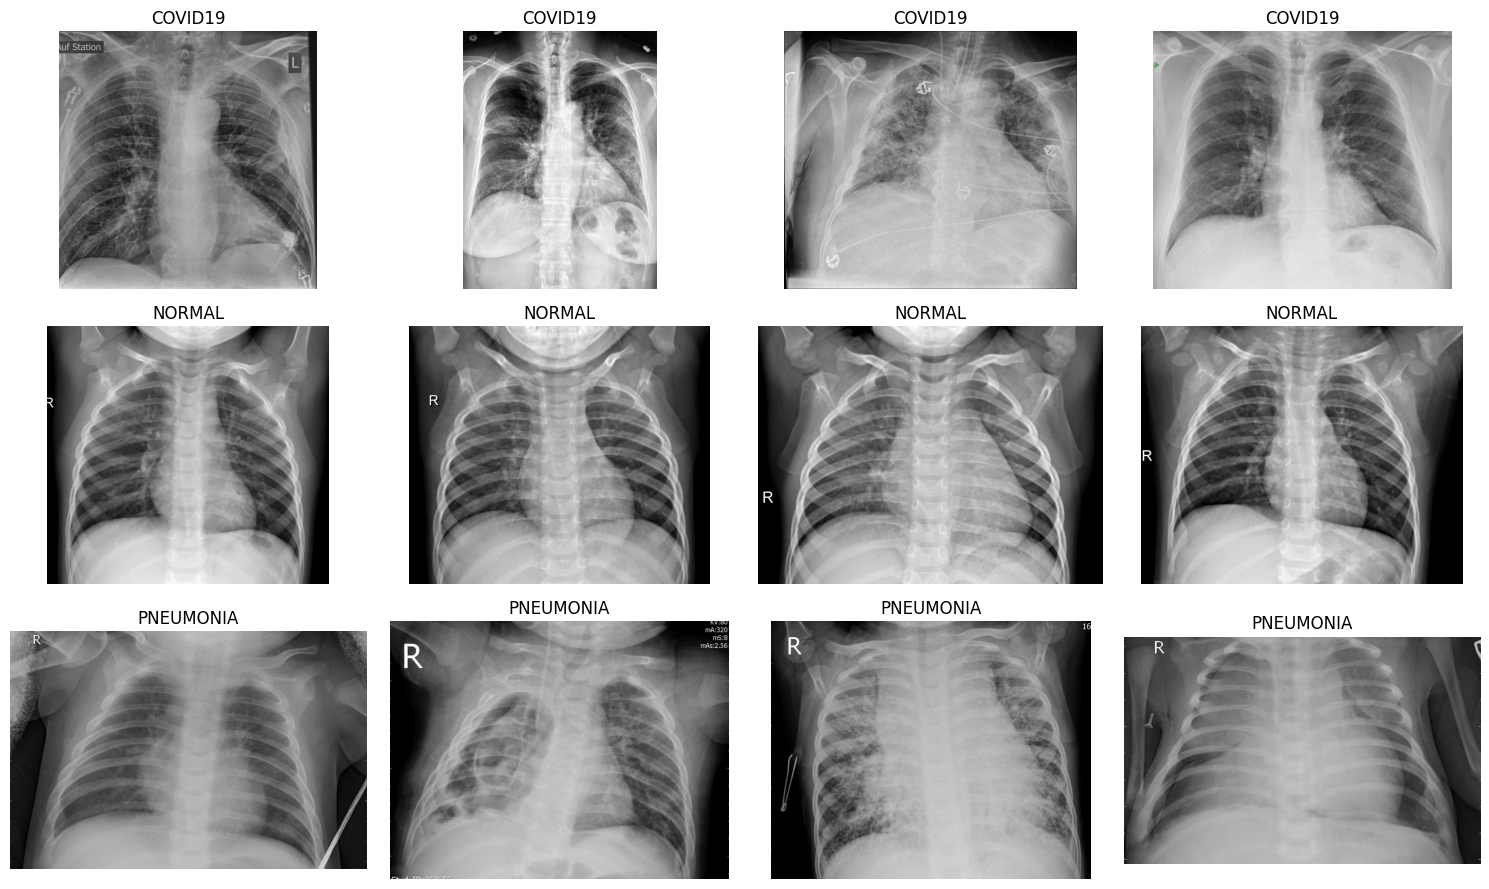

In [14]:
def plot_images(image_paths, titles, num_cols=4):
    """Plot a grid of images with titles"""
    num_images = len(image_paths)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    print(num_images)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten() if num_rows > 1 or num_cols > 1 else [axes]
    
    for i, (img_path, title) in enumerate(zip(image_paths, titles)):
        if i < len(axes):
            img = Image.open(img_path).convert('RGB')
            axes[i].imshow(img)
            axes[i].set_title(title)
            axes[i].axis('off')
    
    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

# Get random sample images from each class
def get_random_images(folder_path, n_per_class=3):
    image_paths = []
    titles = []
    
    for cls in classes:
        class_path = os.path.join(folder_path, cls)
        class_images = os.listdir(class_path)
        selected_images = random.sample(class_images, min(n_per_class, len(class_images)))
        
        for img_name in selected_images:
            img_path = os.path.join(class_path, img_name)
            image_paths.append(img_path)
            titles.append(f"{cls}")
    
    return image_paths, titles

# Get and plot random training images
train_image_paths, train_titles = get_random_images(train_path, n_per_class=4)
plot_images(train_image_paths, train_titles)

## 3. Visualize Individual Preprocessing Steps

Let's visualize the effect of each preprocessing step we're applying to the X-ray images.

Preprocessing steps on a Normal X-ray:


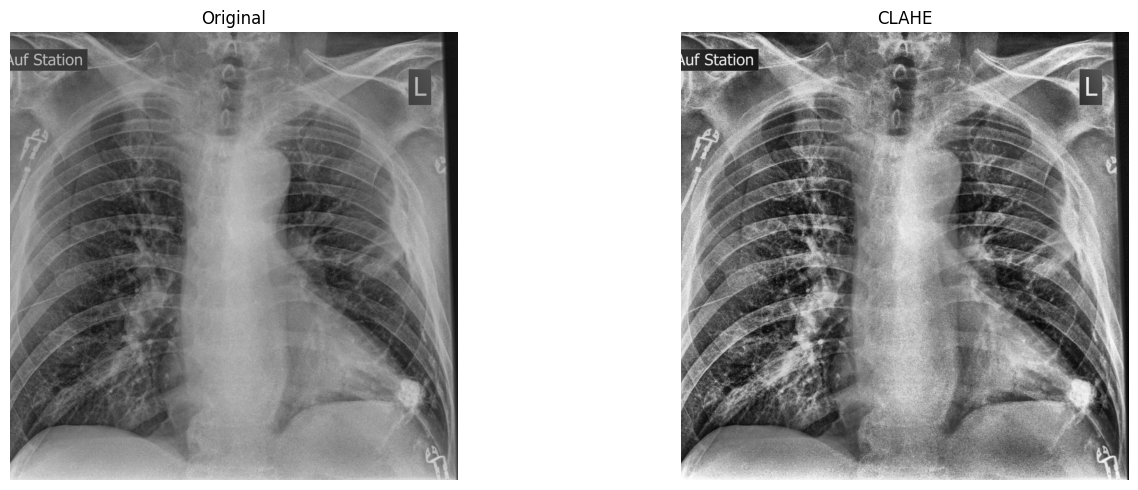

Preprocessing steps on a Pneumonia X-ray:


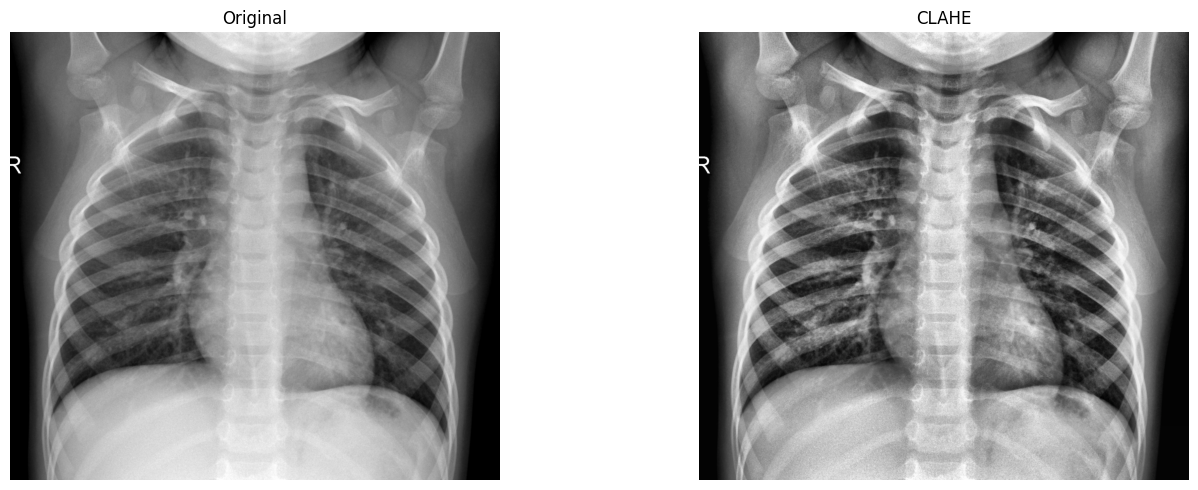

In [23]:
def apply_and_visualize_transform(img_path, transform_functions):
    """Apply a series of transforms to an image and visualize the results"""
    # Load original image
    original_img = load_img(img_path)
    
    # Apply each transform
    transformed_imgs = [original_img]
    titles = ['Original']
    
    for name, transform_fn, args in transform_functions:
        transformed = transform_fn(transformed_imgs[-1], **args)
        transformed_imgs.append(transformed)
        titles.append(name)
    
    # Convert tensors to numpy for display
    display_imgs = [img.permute(1, 2, 0).numpy() for img in transformed_imgs]
    
    # Normalize float images for display
    display_imgs = [img if img.dtype == np.uint8 else (img * 255).astype(np.uint8) for img in display_imgs]
    
    # Plot the results
    fig, axes = plt.subplots(1, len(display_imgs), figsize=(15, 5))
    
    for ax, img, title in zip(axes, display_imgs, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Let's select a couple of images to show the preprocessing steps
selected_normal = train_image_paths[0]  # First normal image
selected_pneumonia = train_image_paths[4]  # First pneumonia image

# Define transform functions to visualize
transform_functions = [
    # ('Median Filter', apply_median_filter, {'kernel_size': 3}),
    # ('Adaptive Gamma', apply_adaptive_gamma, {'gamma_range': (0.8, 1.2)}),
    ('CLAHE', apply_clahe, {'clip_limit': 2.0, 'tile_grid_size': (8, 8)}),
    # ('Unsharp Masking', apply_unsharp_masking, {'kernel_size': 5, 'sigma': 1.0, 'amount': 0.5, 'threshold': 10})
]

print("Preprocessing steps on a Normal X-ray:")
apply_and_visualize_transform(selected_normal, transform_functions)

print("Preprocessing steps on a Pneumonia X-ray:")
apply_and_visualize_transform(selected_pneumonia, transform_functions)

## 4. Visualize Full Preprocessing Pipeline

Now let's visualize the complete preprocessing pipeline, which includes all the steps applied sequentially.

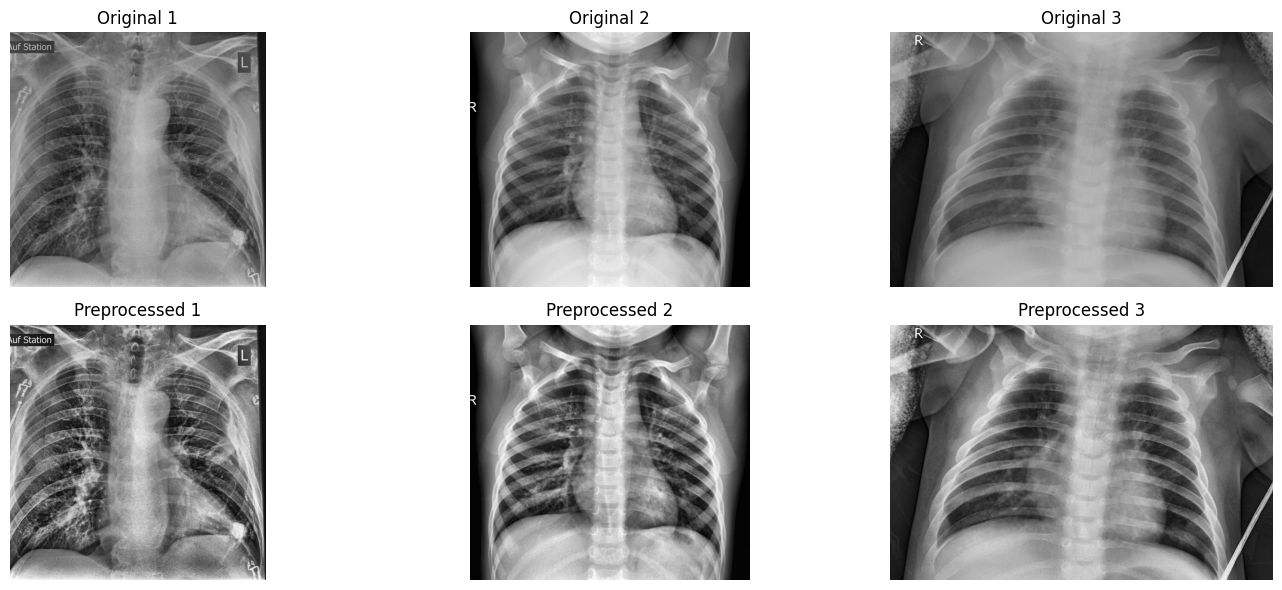

In [16]:
def apply_full_preprocessing(img_tensor):
    """Apply all preprocessing steps in sequence"""
    img = img_tensor
    img = apply_median_filter(img, kernel_size=3)
    img = apply_adaptive_gamma(img, gamma_range=(0.8, 1.2))
    img = apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8))
    img = apply_unsharp_masking(img, kernel_size=5, sigma=1.0, amount=0.5, threshold=10)
    return img

def compare_original_vs_preprocessed(img_paths):
    """Compare original images with their preprocessed versions"""
    num_images = len(img_paths)
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i, img_path in enumerate(img_paths):
        # Load and preprocess image
        original = load_img(img_path)
        preprocessed = apply_full_preprocessing(original)
        
        # Convert to numpy for display
        original_np = original.permute(1, 2, 0).numpy()
        preprocessed_np = preprocessed.permute(1, 2, 0).numpy()
        
        # Display
        axes[0, i].imshow(original_np)
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(preprocessed_np)
        axes[1, i].set_title(f"Preprocessed {i+1}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Select a few images to compare
selected_images = [train_image_paths[i] for i in [0, 4, 8]]
compare_original_vs_preprocessed(selected_images)

## 5. Visualize Data Augmentation

Finally, let's visualize the data augmentation techniques we're applying during training.

Augmentations on a Normal X-ray:


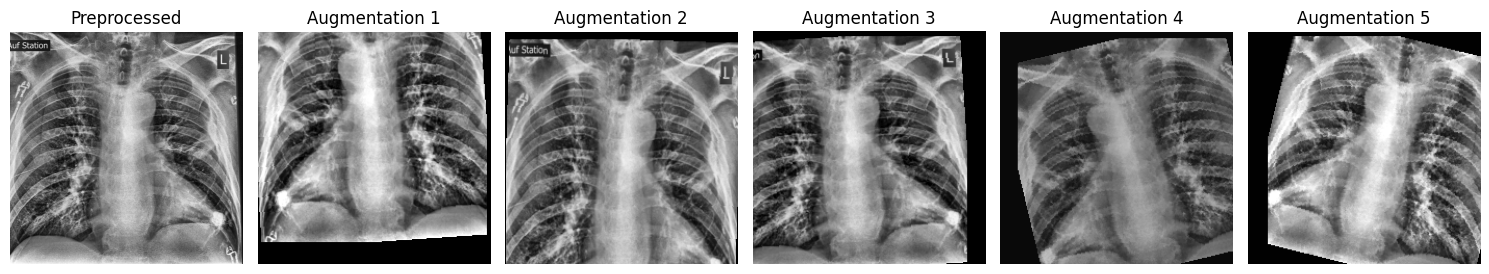

Augmentations on a Pneumonia X-ray:


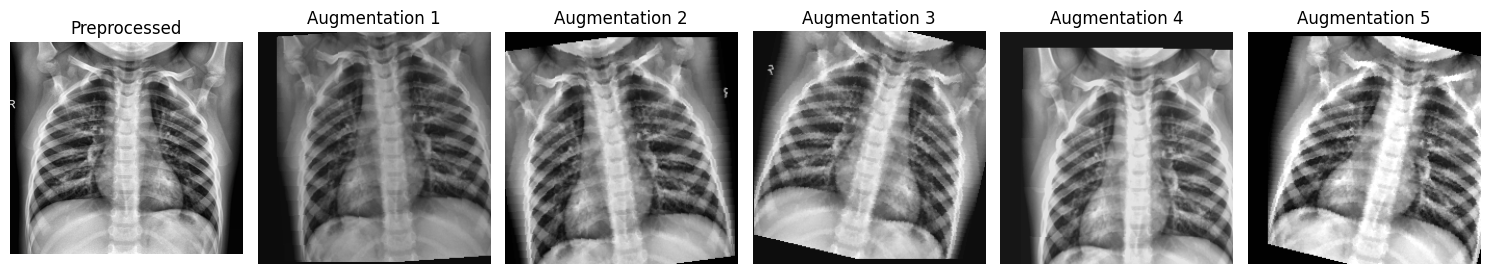

In [17]:
def apply_augmentation(img_tensor, seed=None):
    """Apply data augmentation techniques"""
    if seed is not None:
        torch.manual_seed(seed)
        random.seed(seed)
    
    # Define augmentation transforms
    augmentations = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.Lambda(lambda img: apply_random_grayscale(img, p=1.0)),  # Force grayscale for demo
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.1)
    ])
    
    return augmentations(img_tensor)

def visualize_augmentations(img_path, n_augmentations=5):
    """Visualize multiple augmented versions of the same image"""
    # Load original image
    original_img = load_img(img_path)
    
    # Apply preprocessing (optional)
    preprocessed_img = apply_full_preprocessing(original_img)
    
    # Create multiple augmented versions
    augmented_imgs = [preprocessed_img]
    for i in range(n_augmentations):
        augmented = apply_augmentation(preprocessed_img, seed=i)
        augmented_imgs.append(augmented)
    
    # Convert tensors to numpy for display
    display_imgs = [img.permute(1, 2, 0).numpy() for img in augmented_imgs]
    
    # Plot the results
    fig, axes = plt.subplots(1, len(display_imgs), figsize=(15, 5))
    
    titles = ['Preprocessed'] + [f'Augmentation {i+1}' for i in range(n_augmentations)]
    
    for ax, img, title in zip(axes, display_imgs, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize augmentations on a few images
print("Augmentations on a Normal X-ray:")
visualize_augmentations(selected_normal)

print("Augmentations on a Pneumonia X-ray:")
visualize_augmentations(selected_pneumonia)

## 6. Compare Original, Preprocessed, and Augmented Images

Let's visualize the complete pipeline from original image to preprocessed to augmented, to understand the full transformation we're applying to training data.

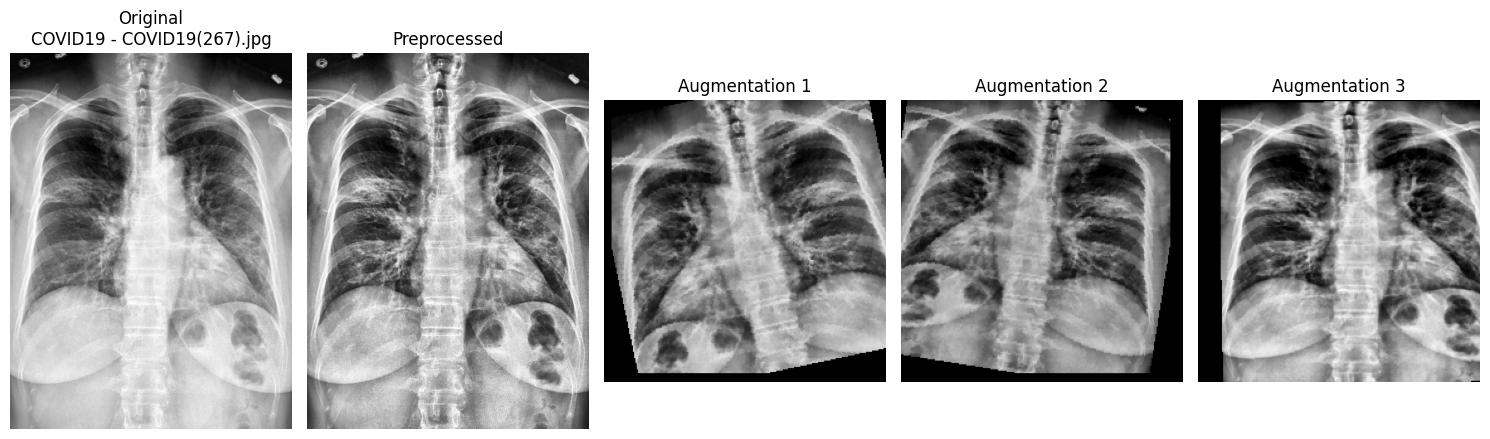

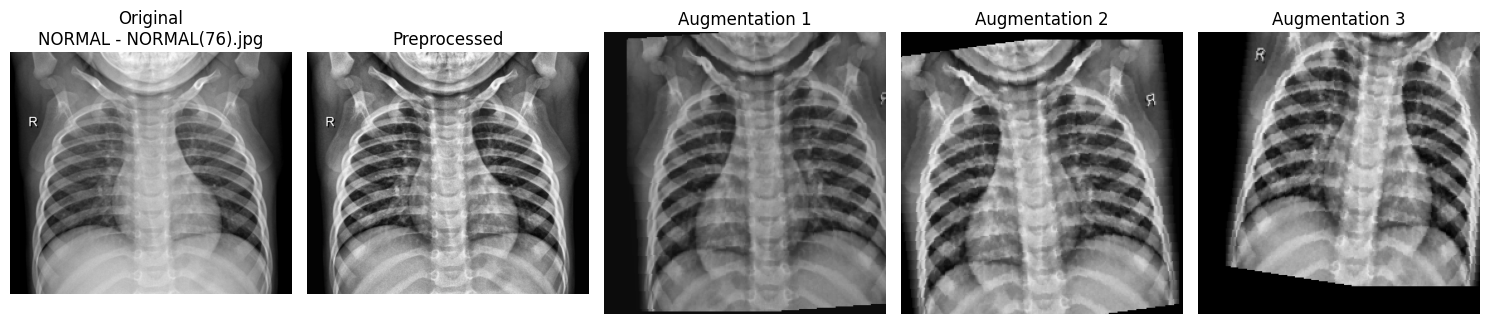

In [18]:
def visualize_full_pipeline(img_paths, n_augmentations=3):
    """Visualize the full pipeline from original to preprocessed to augmented"""
    for img_path in img_paths:
        class_name = os.path.basename(os.path.dirname(img_path))
        img_name = os.path.basename(img_path)
        
        # Load original image
        original_img = load_img(img_path)
        
        # Apply preprocessing
        preprocessed_img = apply_full_preprocessing(original_img)
        
        # Apply multiple augmentations
        augmented_imgs = []
        for i in range(n_augmentations):
            augmented = apply_augmentation(preprocessed_img, seed=i)
            augmented_imgs.append(augmented)
        
        # Convert tensors to numpy for display
        original_np = original_img.permute(1, 2, 0).numpy()
        preprocessed_np = preprocessed_img.permute(1, 2, 0).numpy()
        augmented_nps = [img.permute(1, 2, 0).numpy() for img in augmented_imgs]
        
        # Plot the results
        fig, axes = plt.subplots(1, 2 + n_augmentations, figsize=(15, 5))
        
        # Original
        axes[0].imshow(original_np)
        axes[0].set_title(f"Original\n{class_name} - {img_name}")
        axes[0].axis('off')
        
        # Preprocessed
        axes[1].imshow(preprocessed_np)
        axes[1].set_title("Preprocessed")
        axes[1].axis('off')
        
        # Augmentations
        for i, (ax, img) in enumerate(zip(axes[2:], augmented_nps)):
            ax.imshow(img)
            ax.set_title(f"Augmentation {i+1}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize the full pipeline on a couple of images
selected_for_pipeline = [train_image_paths[i] for i in [1, 5]]
visualize_full_pipeline(selected_for_pipeline)

## 7. Dataset Metadata Analysis

Let's analyze some metadata from the dataset, such as class distribution and image properties.

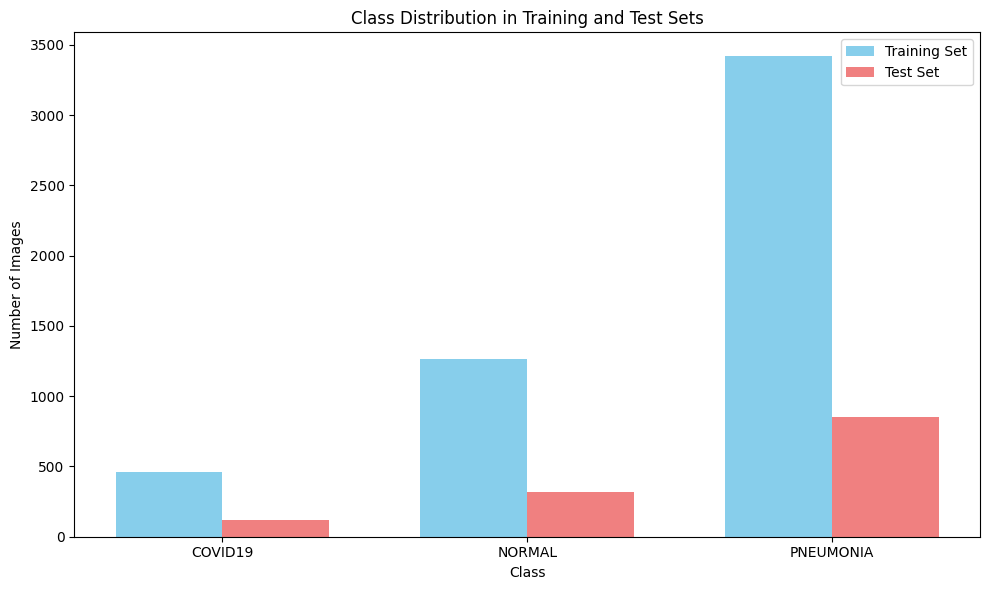

Image Properties:
Average dimensions: 1520.1 x 1227.5
Dimension range: Width 394 to 5623, Height 164 to 4757
Average aspect ratio: 1.30


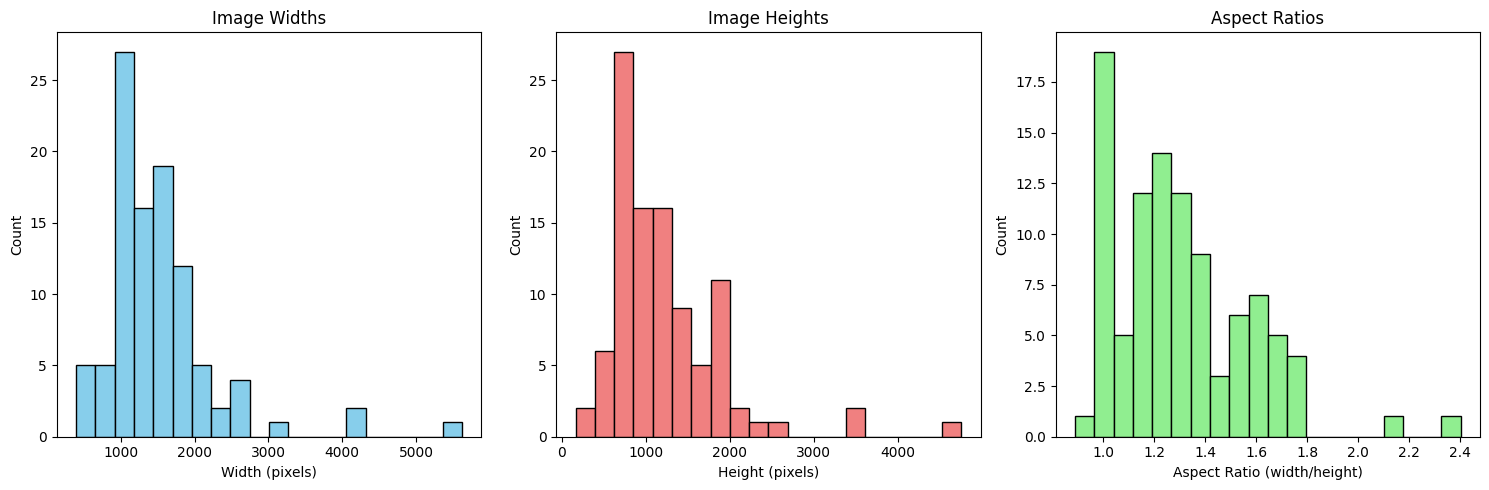

In [19]:
# Analyze class distribution
train_distribution = {cls: count for cls, count in train_counts.items()}
test_distribution = {cls: count for cls, count in test_counts.items()}

# Plot class distribution
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(classes))

plt.bar(index, [train_distribution[cls] for cls in classes], bar_width, 
        label='Training Set', color='skyblue')
plt.bar(index + bar_width, [test_distribution[cls] for cls in classes], bar_width,
        label='Test Set', color='lightcoral')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training and Test Sets')
plt.xticks(index + bar_width/2, classes)
plt.legend()
plt.tight_layout()
plt.show()

# Analyze image properties (dimensions, channels)
def analyze_image_properties(folder_path, max_images=100):
    """Analyze properties of images in the dataset"""
    widths = []
    heights = []
    aspect_ratios = []
    
    for cls in classes:
        class_path = os.path.join(folder_path, cls)
        class_images = os.listdir(class_path)
        
        # Limit number of images to analyze
        sample_images = random.sample(class_images, min(max_images // len(classes), len(class_images)))
        
        for img_name in sample_images:
            img_path = os.path.join(class_path, img_name)
            with Image.open(img_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
                aspect_ratios.append(width / height)
    
    return {
        'widths': widths,
        'heights': heights,
        'aspect_ratios': aspect_ratios,
        'avg_width': np.mean(widths),
        'avg_height': np.mean(heights),
        'avg_aspect_ratio': np.mean(aspect_ratios),
        'min_width': np.min(widths),
        'max_width': np.max(widths),
        'min_height': np.min(heights),
        'max_height': np.max(heights)
    }

# Analyze training images
train_properties = analyze_image_properties(train_path)

print("Image Properties:")
print(f"Average dimensions: {train_properties['avg_width']:.1f} x {train_properties['avg_height']:.1f}")
print(f"Dimension range: Width {train_properties['min_width']} to {train_properties['max_width']}, " 
      f"Height {train_properties['min_height']} to {train_properties['max_height']}")
print(f"Average aspect ratio: {train_properties['avg_aspect_ratio']:.2f}")

# Plot histograms of image dimensions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.hist(train_properties['widths'], bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Image Widths')
ax1.set_xlabel('Width (pixels)')
ax1.set_ylabel('Count')

ax2.hist(train_properties['heights'], bins=20, color='lightcoral', edgecolor='black')
ax2.set_title('Image Heights')
ax2.set_xlabel('Height (pixels)')
ax2.set_ylabel('Count')

ax3.hist(train_properties['aspect_ratios'], bins=20, color='lightgreen', edgecolor='black')
ax3.set_title('Aspect Ratios')
ax3.set_xlabel('Aspect Ratio (width/height)')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()